In [2]:
import numpy as np
import random
import os
import keras_tuner as kt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers
import pandas as pd
from tqdm.notebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy import signal


from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from utils.augment import noise_augment, shift_augment, apply_augment
from utils.deep import preProcess, smoothLabels, oneHot, applyOneHot, evaluate_set, m2tex
from utils.visualize import showMe, showHistory
from config.default import *

%load_ext autoreload
%autoreload 2


C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
root_path = 'C:/resources/EMG/'
post_fix = '_1s_cleaned' #'_1s_new' #
classes = settings['classes']


sessions_to_val = [] #'session_4'] # ['session_1','session_2','session_3','session_4']    #[] # 
subject_to_val = ['S001',  'S105']

# use session4 for validation
train_sessions = []
val_sessions = []
for subject in os.listdir(root_path):
        for session in os.listdir(os.path.join(root_path,subject)):
            if session in sessions_to_val or subject in subject_to_val:
                val_sessions.append(os.path.join(root_path,subject, session))
            else:
                train_sessions.append(os.path.join(root_path,subject, session))
        #print(f"{len(os.listdir(os.path.join(root_path,subject)))} session loaded from subject: {subject}")




train_records = {}
if len(train_sessions) > 0:
    for c in classes:
        class_data = []
        for session in train_sessions:
            data = np.load(os.path.join(session,c+post_fix+'.npy'),allow_pickle=True)
            if data.shape[0] != 0:
                class_data.append(data)
            else:
                #val_records[c] = np.random.rand(1, 4, 500)
                #print(f'WARNING! CREATING RANDOM DATA FOR {c}')
                print(f"No data available for train for class {c}")
        
        train_records[c] = np.concatenate(class_data)
    print(f"{len(train_sessions)} sessions loaded for training")
else:
    print("No train session available")

val_records = {}
for c in classes:
    class_data = []
    for session in val_sessions:
        data = np.load(os.path.join(session,c+post_fix+'.npy'),allow_pickle=True)
        if data.shape[0] != 0:
            class_data.append(data)
    if len(class_data) != 0:
        val_records[c] = np.concatenate(class_data)
    else:
        #val_records[c] = np.random.rand(1, 4, 500)
        #print(f'WARNING! CREATING RANDOM DATA FOR {c}')
        print(f"No data available for validation for class {c}")

print(f"{len(val_sessions)} sessions loaded for validation")

No data available for train for class Chew
No data available for train for class Chew
No data available for train for class Chew
No data available for train for class Smile
No data available for train for class Smile
No data available for train for class Smile
No data available for train for class Smile
No data available for train for class Smile
No data available for train for class Smile
No data available for train for class Smile
No data available for train for class Smile
50 sessions loaded for training
8 sessions loaded for validation


In [4]:
def create_labels(X):
    y = []
    for i, r in enumerate(X):
        l = np.ones(X[r].shape[0])*i
        y = y + l.tolist()
    y = np.array(y)
    return y

In [5]:
print("TRAIN SET")
for r in train_records:
    print(f'{r} -> {train_records[r].shape}')

print("VAL SET")
for r in val_records:
    print(f'{r} -> {val_records[r].shape}')

TRAIN SET
Rest -> (2088, 4, 500)
Eyebrow -> (2880, 4, 500)
Chew -> (1866, 4, 500)
Smile -> (1215, 4, 500)
VAL SET
Rest -> (201, 4, 500)
Eyebrow -> (519, 4, 500)
Chew -> (294, 4, 500)
Smile -> (285, 4, 500)


In [6]:
n_channels = train_records["Rest"].shape[1]
input_length = train_records["Rest"].shape[2]


print('Train')
train_y = create_labels(train_records)
train_X = np.concatenate((list(train_records.values())), axis=0)
print(train_X.shape)
print(train_y.shape)


print('Validation:')
val_y = create_labels(val_records)
val_X = np.concatenate((list(val_records.values())), axis=0)
print(val_X.shape)
print(val_y.shape)

Train
(8049, 4, 500)
(8049,)
Validation:
(1299, 4, 500)
(1299,)


In [7]:
train_X = np.array(train_X).reshape(-1,n_channels,input_length)
train_y = np.array(train_y)

val_X = np.array(val_X).reshape(-1,n_channels,input_length)
val_y = np.array(val_y)


train_y = applyOneHot(train_y,len(classes))
val_y = applyOneHot(val_y,len(classes))


print(train_X.shape)
print(train_y.shape)

print(val_X.shape)
print(val_y.shape)


(8049, 4, 500)
(8049, 4)
(1299, 4, 500)
(1299, 4)


In [8]:
train_X, train_y = apply_augment(train_X, train_y)
print("After augmentation")
print(train_X.shape)
print(train_y.shape)


After augmentation
(24147, 4, 500)
(24147, 4)


In [8]:
c = list(zip(train_X, train_y))
random.seed(42)
random.shuffle(c)
train_X,train_y = zip(*c)
train_X = np.array(train_X)
train_y = np.array(train_y)

In [65]:
def get_model():
    inspected_chanels= train_X.shape[1]
    input_length=     train_X.shape[2]
    l2 = 0.000001

    input_layer = keras.Input(shape = (inspected_chanels,input_length,1), name='input')

    x     = layers.AveragePooling2D(pool_size=(1,5))(input_layer) # resample


   
   
    x     = layers.Conv2D(256, kernel_size=(1,5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.AveragePooling2D(pool_size=(1,5))(x)

    x     = layers.Conv2D(64, kernel_size=(4,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.AveragePooling2D(pool_size=(4,1))(x)

    x     = layers.Dense(100,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.Flatten()(x)

 
   
    x     = layers.Dense(20,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.1)(x)

    


    output = layers.Dense(len(classes), activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    #model.summary()
    return model

In [76]:
model = get_model()


reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.5,
                             min_delta=0.001,
                             patience=2,
                             min_lr=5e-8,
                             verbose = 1)
                              
# early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.000001)

opt = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(optimizer=opt,
          loss='categorical_crossentropy',
          metrics=['categorical_accuracy']
         )


In [81]:
model.summary()

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 4, 500, 1)]       0         
_________________________________________________________________
average_pooling2d_39 (Averag (None, 4, 100, 1)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 100, 256)       1536      
_________________________________________________________________
batch_normalization_38 (Batc (None, 4, 100, 256)       1024      
_________________________________________________________________
average_pooling2d_40 (Averag (None, 4, 20, 256)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 4, 20, 64)         65600     
_________________________________________________________________
batch_normalization_39 (Batc (None, 4, 20, 64)       

Epoch 1/30
189/189 [==============================] - 4s 20ms/step - loss: 0.9165 - categorical_accuracy: 0.6619 - val_loss: 1.5359 - val_categorical_accuracy: 0.2263
Epoch 2/30
189/189 [==============================] - 3s 18ms/step - loss: 0.7057 - categorical_accuracy: 0.7995 - val_loss: 1.4507 - val_categorical_accuracy: 0.2895
Epoch 3/30
189/189 [==============================] - 4s 19ms/step - loss: 0.5933 - categorical_accuracy: 0.8564 - val_loss: 0.9261 - val_categorical_accuracy: 0.6774
Epoch 4/30
189/189 [==============================] - 4s 19ms/step - loss: 0.5300 - categorical_accuracy: 0.8811 - val_loss: 0.6728 - val_categorical_accuracy: 0.8160
Epoch 5/30
189/189 [==============================] - 4s 19ms/step - loss: 0.4998 - categorical_accuracy: 0.8938 - val_loss: 0.5793 - val_categorical_accuracy: 0.8491
Epoch 6/30
189/189 [==============================] - 4s 19ms/step - loss: 0.4772 - categorical_accuracy: 0.9018 - val_loss: 0.5295 - val_categorical_accuracy: 0.884

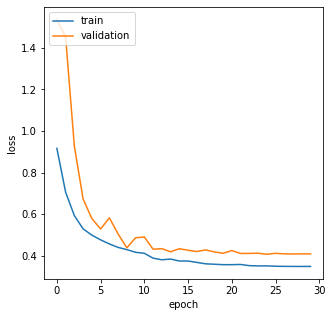

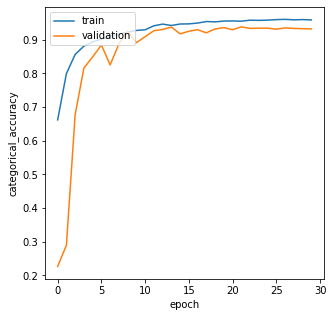

0.9384141564369202


In [78]:
##############################################
############     TRAIN MODEL     #############
##############################################

batch_size = 128
history = model.fit(train_X,
                    train_y,
                    validation_data=(val_X, val_y),
                    batch_size=batch_size,
                    epochs=30,
                    shuffle=True,
                    callbacks = [reduce_lr]
                    )

showHistory(history)      
try:    
    acc = max(history.history['val_accuracy'])
except:
    acc = max(history.history['val_categorical_accuracy'])

print(acc)

In [79]:
evaluate_set(model, train_sessions, classes, post_fix, input_length=input_length, log = False)

  0%|          | 0/50 [00:00<?, ?it/s]

Global accuracy: 96.46%
          Accuracy
Subject           
S002     92.000000
S004     97.500000
S005     94.250000
S006     95.000000
S007     92.250000
S008     98.250000
S009     96.250000
S010     98.500000
S011     99.000000
S101     99.500000
S102     98.500000
S103     97.666667
S104     95.000000
S106     95.000000


In [80]:
evaluate_set(model, val_sessions, classes,  post_fix, input_length=input_length, log = False)

  0%|          | 0/8 [00:00<?, ?it/s]

Global accuracy: 92.0%
         Accuracy
Subject          
S001           97
S105           87


In [82]:
model.save('saved_models/04_03_val_acc_92_100k_param')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/04_03_val_acc_92_100k_param\assets


In [83]:


m2tex(model)

\begin{table}[] 
\begin{tabular}{lll} 
Model: test \\ \hline 
Layer (type)                   & Output Shape                & Param \#    \\ \hline \hline 
input (InputLayer)             & [(None, 4, 500, 1)]         & 0          \\ \hline 
average\_pooling2d\_39 (AverageP & (None, 4, 100, 1)           & 0          \\ \hline 
conv2d\_26 (Conv2D)             & (None, 4, 100, 256)         & 1536       \\ \hline 
batch\_normalization\_38 (BatchN & (None, 4, 100, 256)         & 1024       \\ \hline 
average\_pooling2d\_40 (AverageP & (None, 4, 20, 256)          & 0          \\ \hline 
conv2d\_27 (Conv2D)             & (None, 4, 20, 64)           & 65600      \\ \hline 
batch\_normalization\_39 (BatchN & (None, 4, 20, 64)           & 256        \\ \hline 
average\_pooling2d\_41 (AverageP & (None, 1, 20, 64)           & 0          \\ \hline 
dense\_38 (Dense)               & (None, 1, 20, 100)          & 6500       \\ \hline 
flatten\_13 (Flatten)           & (None, 2000)                & 0  